In [1]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
from cgc_funcs import calculate_C, p_ox
from pandas import read_excel, read_csv
from io_tools import sim_path
import plot_settings # my personal default settings for matplotlib

Stovanovic (2006) approximation for Inductance, solve for N

In [2]:
H = 100
W = 10
d = 30
A = 100
L = 3.2

estimate_N_turns = lambda L,a,h,d,w: ( L/(.00266*a**.0603 * h**0.4429 * d**0.606 * w**(-.173)) )**(1/.954)
L_tot = lambda a,N,d: (N+1)*d+2*a

Ntot = estimate_N_turns(L,A,H,d,W)
length = L_tot(A,Ntot,d)

print("Calculated number of half-turns: ", int(Ntot))
print("Calculated length: %5.2f um " % length)

Calculated number of half-turns:  26
Calculated length: 1013.49 um 


**Calculating parallel plate capacitance**

Calculate the capacitance for our base design using the standard formula for a parallel plate capacitor, neglecting fringe fields and metal oxide:

In [3]:
eps0 = 8.85*10**(-12)
A_base =(300 * 10**(-6))**2 # initial capacitor: 300 um x 300 um square
d_base = 10 * 10**(-6) # initial cap spacing is 10 um

calculate_C(eps0, A_base, d_base)
#interact(calculate_C, A=fixed(A_base), d=(1E-6, 15E-6, 1E-6))


7.964999999999998e-14

**Calculating oxide participation ratio**

The oxide participation ratio is derived in Appendix A of the accompanying report. This will vary inversely with the size of the capacitor gap, eventually reaching a point where additional gap size doesn't reduce $p_{ox}$ any further

In [4]:
t = 5E-9 # 5 nm oxide thickness
eps_r = 10 # relative permittivity of oxide
d_arr = np.linspace(1,20,1000) # FYI: I'm scaling everything by 10E6 for simpler plot

#normalize the dimensions of the device to microns
pox_arr = p_ox(A_base*1E12, t*1E6, d_arr, eps_r )




Get the simulated results and plot against the analytical results for comparison

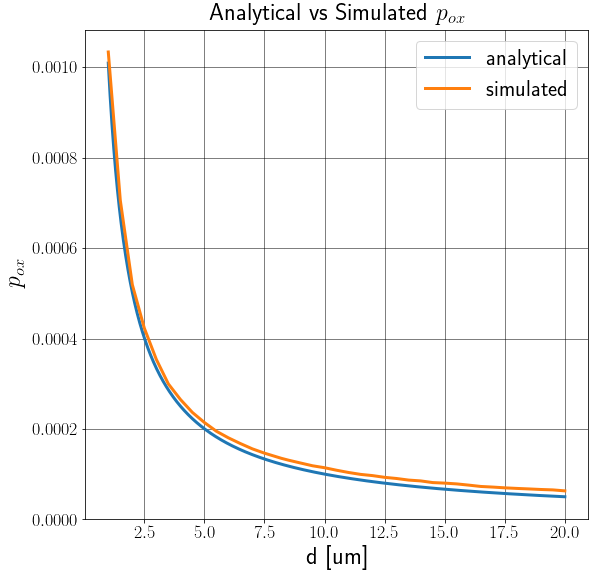

In [6]:
pox_sim = "%s\%s" % (sim_path, "pox_t=5_L=300.csv")
pox_df = read_csv(pox_sim)

fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111)
ax.plot(d_arr, pox_arr)
ax.plot(pox_df.loc[:, "d [um]"], pox_df.loc[:,"F_ox []"])
ax.set_title(r'Analytical vs Simulated $p_{ox}$')
ax.set_xlabel("d [um]")
ax.set_ylabel(r'$p_{ox}$')
plt.grid()
ax.legend(["analytical", "simulated"])
plt.savefig(plot_settings.FIG_DIR+"p_ox")


Great agreement!

**Simulating fringe participation**

Increasing the capacitor gap $d$ drives down $p_{ox}$, but also starts to invalidate the $L>>d$ approximation for parallel plate capacitance. I simulated this effect as follows:

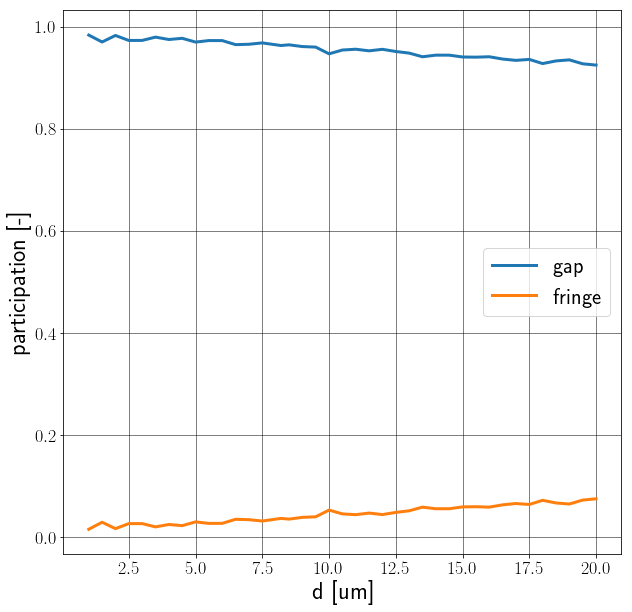

In [8]:
pvac_sim = "%s\%s" % (sim_path, "pvac_t=5_L=300.csv")
pvac_df = read_csv(pvac_sim)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(pox_df.loc[:, "d [um]"], pvac_df.loc[:,"F_gap []"])
ax.plot(pox_df.loc[:, "d [um]"], pvac_df.loc[:,"F_fringe []"])
ax.set_xlabel("d [um]")
ax.set_ylabel("participation [-]")
plt.grid()
ax.legend(["gap", "fringe"])
plt.savefig(plot_settings.FIG_DIR+"p_vac_p_gap")

